In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.script import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastai.callbacks.tracker import *

torch.backends.cudnn.benchmark = True

import time

In [3]:
import fastai;fastai.__version__ #safety check

'1.0.57'

In [4]:
import torch; torch.__version__ #safety check

'1.2.0'

In [5]:
#from autoadam import AutoAdam

In [6]:
from diffgrad import DiffGrad

In [7]:
#from ranger_diffgrad1 import Ranger_DiffGrad

In [8]:
#from mixnet import MixNet

In [9]:
#from ranger import Ranger

In [10]:
from mxresnet import *

Mish activation loaded...


In [11]:
path = untar_data(URLs.IMAGEWOOF_160); path  #optional - IMAGENETTE

PosixPath('/home/ubuntu/.fastai/data/imagewoof-160')

In [12]:
def flattenAnneal(learn:Learner, lr:float, n_epochs:int, start_pct:float):
  n = len(learn.data.train_dl)
  anneal_start = int(n*n_epochs*start_pct)
  anneal_end = int(n*n_epochs) - anneal_start
  phases = [TrainingPhase(anneal_start).schedule_hp('lr', lr),
           TrainingPhase(anneal_end).schedule_hp('lr', lr, anneal=annealing_cos)]
  sched = GeneralScheduler(learn, phases)
  learn.callbacks.append(sched)
  learn.fit(n_epochs)


In [14]:
tfms = ([

        flip_lr(p=0.5)#,
        #brightness(change=(0.4,0.6)),
        #contrast(scale=(0.7,1.3)),
        #cutout(n_holes=(2,40),length=(5,30),p=.25)

    ], [])

In [15]:
bs=64
size=128

In [16]:
data = (ImageList.from_folder(path)
        .split_by_folder(valid='val')
        .label_from_folder()
        .transform(tfms=tfms,size=size) 
        .databunch(bs=bs, num_workers=8)  #windows 10 users - num_workers may need to be set to 1 or 0 (if you get pickle fork error)
        .presize(size, scale=(0.35, 1))
        .normalize(imagenet_stats))

In [17]:
#learn.purge;learn.destroy  # to reset learner if needed

In [18]:
from mxresnet import *

In [19]:
from diffgrad import DiffGrad

In [20]:
optar = partial(DiffGrad, version=1, betas=(.95,.999),eps=1e-6)

In [21]:
model = mxresnet50(sa=1)

In [22]:
learn = Learner(data, model, metrics=[accuracy], wd=1e-3,
                opt_func=optar,
                 bn_wd=False, true_wd=True,
                loss_func = LabelSmoothingCrossEntropy())

In [23]:
learn.callback_fns += [
        partial(ShowGraph),
        #partial(SaveModelCallback, name='model-novotest-1')
    ]

epoch,train_loss,valid_loss,accuracy,time
0,2.758223,2.762700,0.320000,00:34
1,2.498939,2.520245,0.392000,00:31
2,2.354712,2.340736,0.460000,00:31
3,2.197485,2.214212,0.526000,00:30
4,2.129957,2.189941,0.550000,00:31
5,2.015059,1.975239,0.662000,00:31
6,1.959366,2.036716,0.636000,00:31
7,1.899160,2.028209,0.660000,00:32
8,1.815370,1.854039,0.698000,00:31
9,1.769482,1.837504,0.694000,00:32


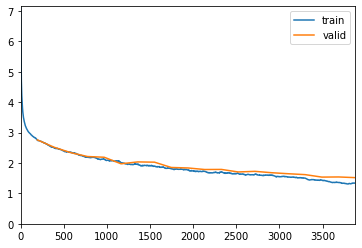

In [24]:
flattenAnneal(learn, 4e-3, 20, .75)

epoch,train_loss,valid_loss,accuracy,time
0,2.833390,2.699824,0.354000,00:35
1,2.548797,2.675118,0.342000,00:33
2,2.391769,2.478258,0.424000,00:32
3,2.267454,2.193657,0.556000,00:31
4,2.182068,2.529324,0.534000,00:32
5,2.055904,2.122666,0.570000,00:33
6,1.954961,2.240763,0.590000,00:32
7,1.864358,1.884452,0.672000,00:33
8,1.795261,1.849918,0.692000,00:32
9,1.734303,1.733793,0.756000,00:32


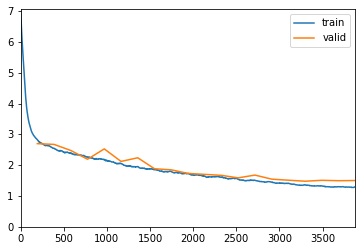

In [22]:
learn.fit_one_cycle(20,8e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.993190,2.822077,0.314000,00:35
1,2.616494,2.665964,0.346000,00:31
2,2.382699,2.424042,0.460000,00:31
3,2.249791,2.478822,0.470000,00:32
4,2.169872,2.319252,0.462000,00:32
5,2.053635,2.265847,0.538000,00:33
6,1.919993,1.876316,0.678000,00:32
7,1.840100,2.183166,0.586000,00:31
8,1.741628,1.788778,0.728000,00:31
9,1.693138,1.887023,0.714000,00:32


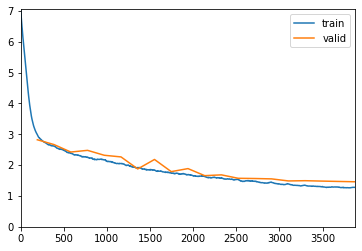

In [22]:
learn.fit_one_cycle(20,4e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.376083,2.543161,0.458000,00:36
1,1.955864,1.932200,0.682000,00:32
2,1.738561,1.641399,0.782000,00:33
3,1.571276,1.508449,0.840000,00:33
4,1.493405,1.445910,0.862000,00:33


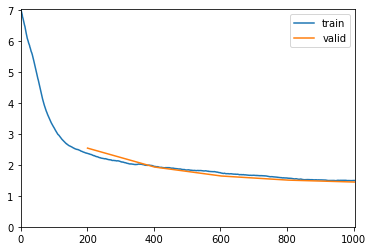

In [22]:
learn.fit_one_cycle(5,4e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.915032,2.821275,0.282000,00:32
1,2.729244,2.614827,0.366000,00:32
2,2.624524,2.643105,0.414000,00:32
3,2.531703,2.401488,0.468000,00:31
4,2.455483,2.492201,0.444000,00:32
5,2.371869,2.160528,0.598000,00:32
6,2.347112,2.045589,0.630000,00:31
7,2.282213,1.993346,0.638000,00:33
8,2.247681,1.904134,0.696000,00:32
9,2.222119,1.896390,0.688000,00:32


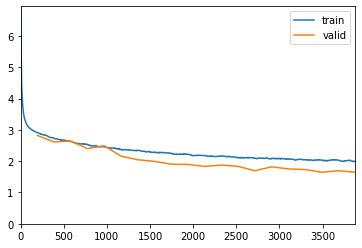

In [30]:
learn.fit(20,3e-3) #v1

epoch,train_loss,valid_loss,accuracy,time
0,2.760318,2.705876,0.308000,00:35
1,2.505301,2.428731,0.454000,00:31
2,2.363295,2.402072,0.432000,00:31
3,2.210432,2.248763,0.500000,00:31
4,2.140493,2.181470,0.542000,00:31
5,2.032414,2.170866,0.576000,00:32
6,1.916482,1.988057,0.630000,00:31
7,1.850592,1.888239,0.682000,00:32
8,1.778943,1.840208,0.708000,00:31
9,1.761827,1.791052,0.740000,00:32


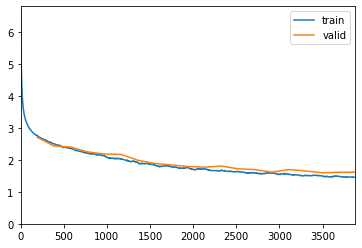

In [22]:
learn.fit(20,4e-3) #v1

In [19]:
#learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


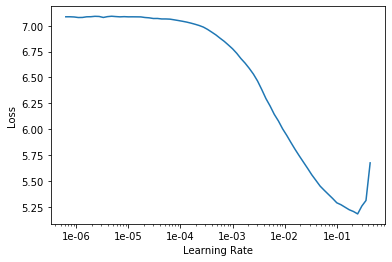

In [20]:
#learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,2.744928,2.662711,0.334000,00:32
1,2.499407,2.528494,0.404000,00:31
2,2.331353,2.525743,0.404000,00:32
3,2.200269,2.270855,0.528000,00:31
4,2.056779,2.089818,0.608000,00:32
5,1.977343,2.151996,0.608000,00:32
6,1.877099,2.284228,0.570000,00:32
7,1.815722,1.897763,0.670000,00:31
8,1.781015,1.874201,0.688000,00:33
9,1.716859,1.780057,0.714000,00:32


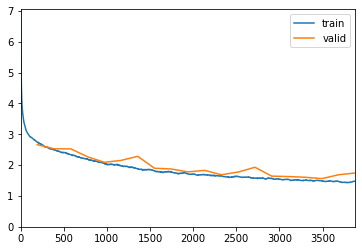

In [21]:
learn.fit(20,4e-3) #v0

epoch,train_loss,valid_loss,accuracy,time
0,2.733951,2.716379,0.350000,00:34
1,2.478821,2.473446,0.426000,00:31
2,2.293517,2.276245,0.532000,00:31
3,2.171782,2.119609,0.578000,00:31
4,2.059656,1.963256,0.638000,00:31
5,1.968898,2.102341,0.600000,00:31
6,1.910046,1.879270,0.682000,00:31
7,1.823214,1.855295,0.702000,00:31
8,1.768201,1.819462,0.702000,00:31
9,1.735258,1.827078,0.716000,00:31


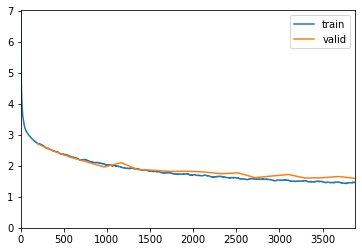

In [20]:
learn.fit(20,4e-3) #v1

[autoreload of diffgrad failed: Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 434, in superreload
    module = reload(module)
  File "/home/ubuntu/anaconda3/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/ubuntu/anaconda3/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/ubuntu/course-v3/nbs

epoch,train_loss,valid_loss,accuracy,time
0,2.710830,2.680972,0.328000,00:35
1,2.413161,2.501697,0.428000,00:31
2,2.245974,2.342880,0.492000,00:31
3,2.116959,2.109904,0.616000,00:31
4,2.009061,2.256759,0.568000,00:31


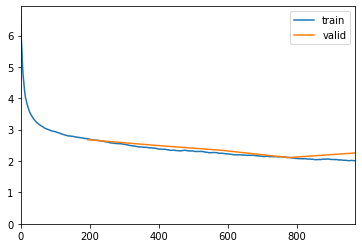

In [18]:
learn.fit(5,4e-3) #v1

epoch,train_loss,valid_loss,accuracy,time
0,2.730675,2.779063,0.298000,00:35
1,2.455382,2.535800,0.394000,00:32
2,2.259683,2.336660,0.466000,00:31
3,2.134786,2.228118,0.558000,00:31
4,2.056129,2.167917,0.588000,00:32


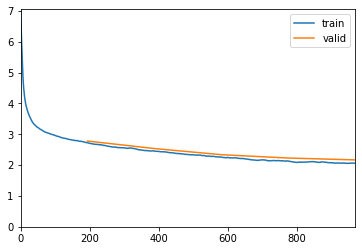

In [17]:
learn.fit(5,4e-3)

In [ ]:
lr = 1e-2

In [ ]:
res = []
num_epoch=5
for x in range(5):
  learn = Learner(data, mxresnet50(c_out=10), wd=1e-2, opt_func=optar,
                 metrics=[accuracy],
                 bn_wd=False, true_wd=True,
                 loss_func=LabelSmoothingCrossEntropy())
  #n = len(learn.data.train_dl)
  #anneal_start = int(n*5*0.7)
  phase0 = TrainingPhase(anneal_start).schedule_hp('lr', lr)
  phase1 = TrainingPhase(n*5 - anneal_start).schedule_hp('lr', lr, anneal=annealing_cos)
  phases = [phase0, phase1]
  sched = GeneralScheduler(learn, phases)
  learn.callbacks.append(sched)
  learn.fit(num_epoch)
  
  loss, acc = learn.validate()
  res.append(acc.numpy())


In [ ]:
#results:
np.mean(res)
print("------")
res
print("std dev: ",np.std(res))